/home/lafleur1/anaconda2/envs/aparent_proj/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


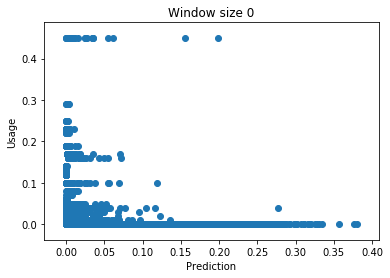

In [2]:
#seeing if any corelation is readily apparent from the raw data outputted by the network



import numpy as np
import sklearn as sk
from sklearn import metrics
import matplotlib.pyplot as plt
import math
import pandas as pd
#Opening GL000219.1 predictions
strideSizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,25,30,35,40,45,50]
bestSizes = [1,2,3]
#opening all unlocalized genomic region names
allUnlocalizedRegionNames = open("UnlocalizedNames.txt", "r")
allNames = allUnlocalizedRegionNames.readlines()
allNames = [x.strip() for x in allNames]
predStem = "./PredictionBinaries/"
#opening all the true values
colnames = ["seqName",  "start" , "end",  "clusterID",  "avgTPM",  "strand",   "percentSupporting",   "protocolsSupporting",  "avgTPM2",   "type",   "upstreamClusters"]
pas_stuff =pd.read_csv('atlas.clusters.hg38.2-0.bed',delimiter='\t', names = colnames)
 

    
def maxPosDist45DegreeLine(fpr,tpr, threshs):
    #fpr is x, tpr is y
    #find the fpr,tpr,and threshold of the ROC point with the maximum positive distance from the 45 degree line
    maxPosDist = -1
    maxIndex = 0
    for i in range(0,len(fpr)):
        if tpr[i] >=fpr[i]: #above or on the 45 degree line
            currPosDist = tpr[i] - fpr[i] #since 45 degree line is y=x
            if currPosDist >= maxPosDist:
                    maxPosDist = currPosDist 
                    maxIndex = i
    if maxPosDist == -1:
        return None
    else:
        return fpr[maxIndex], tpr[maxIndex], threshs[maxIndex], maxPosDist


def findSpecifictySensitivityEqualityPoint(fpr,tpr,threshs):
    #find the prediction closest to where sensitivity=specificity
    minDiff = math.sqrt(2) #maximum possible distance for the unit cube of the ROC curve
    minIndex = 0
    for i in range(0,len(fpr)):
        if fpr[i] != 0.0 and tpr[i] != 0.0: #will always choose (0,0) if not blocked from doing so
            se = tpr[i]
            sp = 1 - fpr[i]
            currDiff = math.fabs(se-sp)
            if currDiff < minDiff:
                minDiff = currDiff
                minIndex = i
    if minDiff != math.sqrt(2):
        return fpr[minIndex], tpr[minIndex], threshs[minIndex], minDiff
    
def minDistanceTopLeftCorner(fpr,tpr,threshs):
    #find the prediction closest to (1,1)
    minDist = math.sqrt(2) #maximum possible distance for the unit cube of the ROC curve
    minIndex = 0
    for i in range(0,len(fpr)):
        currDist = math.sqrt((fpr[i])**2 + (1-tpr[i])**2)
        #print (currDist)
        if currDist < minDist:
            minDist = currDist
            minIndex = i
    if minDist != math.sqrt(2):
        return fpr[minIndex], tpr[minIndex], threshs[minIndex], minDist

    
    
def ROCAllStrideLengthsAllRegions(names,strides):
    fprs = []
    tprs = []
    threshs = []
    aucs = []
    raw_preds = []
    usage = []
    avgPrecs = []
    dist45 = {'fpr':[], 'tpr':[], 'thresholds':[], 'values':[]}
    minEqual = {'fpr':[], 'tpr':[], 'thresholds':[], 'values':[]}
    topLeft = {'fpr':[], 'tpr':[], 'thresholds':[], 'values':[]}
    confMat = []
    for stride in strides:
        allPreds = np.empty(0)
        allTrue = np.empty(0)
        usageTrue = np.empty(0)
        totalAPA = 0
        for name in names:
            #open predicted values for the file
            nameNoDot = name.replace(".","_")
            extenedCutPredStem = "./PredictionBinaries/" + name + "Predictions/" + nameNoDot + "_cutPredsStrideLen" 
            predForSlide = np.load(extenedCutPredStem + str(stride) + ".npy")
            #open true values for the region
            trueValBoolMask = pas_stuff['seqName'] == name
            currentTrueVals = pas_stuff[trueValBoolMask]
            trueValsArray = np.zeros(predForSlide.size) #create numpy array of all 0's the length of the sequence
            trueValsArrayUsage = np.zeros(predForSlide.size)
            for index, row in currentTrueVals.iterrows():
                trueValsArray[row['start']:row['end']] = 1 #set actual true values to 1 in the array 
                trueValsArrayUsage[row['start']:row['end']] = row['percentSupporting']
                totalAPA += 1
            #append both to the 
            predReshape = np.reshape(predForSlide, trueValsArray.shape)
            allTrue = np.concatenate((allTrue,trueValsArray))
            allPreds = np.concatenate((allPreds,predReshape))
            usageTrue = np.concatenate((usageTrue,trueValsArrayUsage ))
        #make ROC and AUC ROC 
        #print ("Total true labelled positions: ", np.sum(allTrue))
        #print ("Total length of all finished contig: ", allTrue.size)
        #print ("Fraction of NT's which are APA sites: ", np.sum(allTrue)/allTrue.size)
        #print ("Number clusters: ", totalAPA)
        raw_preds.append(allPreds)
        usage.append(usageTrue)
        fpr,tpr,thresholds = sk.metrics.roc_curve(allTrue, allPreds)
        auc_score = sk.metrics.roc_auc_score(allTrue,allPreds)
        avgP = sk.metrics.average_precision_score(allTrue,allPreds)
        fprs.append(fpr)
        tprs.append(tpr)
        threshs.append(thresholds)
        aucs.append(auc_score)
        avgPrecs.append(avgP)
        posDistFPR, posDistTPR, posDistThresh, x  = maxPosDist45DegreeLine(fpr,tpr,thresholds)
        dist45['fpr'].append(posDistFPR)
        dist45['tpr'].append(posDistTPR)
        dist45['thresholds'].append(posDistThresh)
        dist45['values'].append(x)
        equalFPR, equalTPR, equalThresh, x  = findSpecifictySensitivityEqualityPoint(fpr,tpr,thresholds)
        minEqual['fpr'].append(equalFPR)
        minEqual['tpr'].append(equalTPR)
        minEqual['thresholds'].append(equalThresh)
        minEqual['values'].append(x)
        closeFPR, closeTPR, closeThresh, x  = minDistanceTopLeftCorner(fpr,tpr,thresholds)
        topLeft['fpr'].append(closeFPR)
        topLeft['tpr'].append(closeTPR)
        topLeft['thresholds'].append(closeThresh)
        topLeft['values'].append(x)
        #updating prediction binaries for confusion matrices
        #cM45Preds = []
        #cMMEPreds = []
        ##cMTLPreds = []      
        #cM = sk.metrics.confusion_matrix(allTrue,allPreds)
        #confMat.append(cM)
    return fprs,tprs,threshs,aucs,dist45,minEqual,topLeft, avgPrecs, confMat, usage, raw_preds
    

   
    
def graphAllROCs(names, sizes):
    fprs,tprs,threshs,aucs,dist45,minEqual,topLeft, avPrec, confusionMat, usage, raw_preds = ROCAllStrideLengthsAllRegions(names, sizes)
    for i in range(0,len(fprs)):
        plt.plot(fprs[i],tprs[i])
    #plt.scatter(dist45['fpr'],dist45['tpr'], c = "blue",label = "Maxmimum Distance from 45")
    #plt.scatter(minEqual['fpr'],minEqual['tpr'], c = "red", label = "Closest to FPR=TPR")
    #plt.scatter(topLeft['fpr'], topLeft['tpr'], c = "green", label = "Closest to (1,1)")
    plt.title("All Regions and Strides ROC Curves")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    #plt.legend()
    plt.show()
    #threshold plots
    print ("MAX THRESHOLDS: ", max(dist45['thresholds']), max(minEqual['thresholds']), max(topLeft['thresholds']))
    plt.scatter(sizes,dist45['thresholds'], c = "blue",label = "Maxmimum Distance from 45")
    plt.scatter(sizes,minEqual['thresholds'], c = "red", label = "Closest to TPR = 1 - FPR")
    plt.scatter(sizes, topLeft['thresholds'], c = "green", label = "Closest to top left corner")
    plt.title("Best threshold values per Stride Length")
    plt.xlabel("Stride Length")
    plt.ylabel("Threshold Value")
    plt.ylim(0,0.001)
    plt.legend()
    plt.show()
    bestAUCStride = sizes[aucs.index(max(aucs))]
    print ("Best AUC is ", max(aucs), " with stride length ",bestAUCStride )
    print ("Thresholds with stride ", bestAUCStride, ":")
    print ("Max Distance from 45: ", dist45['thresholds'][aucs.index(max(aucs))])
    print ("Closest to SE=SP: ", minEqual['thresholds'][aucs.index(max(aucs))])
    print ("Closest to top left: ", topLeft['thresholds'][aucs.index(max(aucs))])
    #print ("Confusion matrix for best ", confusionMat[aucs.index(max(aucs))])
    #graph distribution of aucs
    plt.plot(sizes,aucs)
    #plt.plot(sizes, avPrec)
    plt.title("ROC AUC vs Window Size for All Window Sizes")
    plt.xlabel("Stride Length")
    plt.ylabel("ROC AUC Score")
    plt.show()
    #print ("Max avg precision is: ", max(avPrec))
        
        
#ROCAllRegionsOneStrideLen(allNames, 50)
#graphAllROCs(allNames, bestSizes) 
fprs,tprs,threshs,aucs,dist45,minEqual,topLeft, avPrec, confusionMat, usage, raw_preds = ROCAllStrideLengthsAllRegions(allNames, [3])
#for usage, raw prediction values see if there is a correlation
for i,row in enumerate(usage):
    plt.scatter(raw_preds[i], row)
    plt.title("Window size " +  str(i))
    plt.ylabel("Usage")
    plt.xlabel("Prediction")
    plt.show()
